# Figure 4 | Unsupervised spatial clustering reveals both discrete & continuous gene expression patterns in the thalamus.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import anndata as ad

import sys
sys.path.append("/code/")
from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_images as cimg
from thalamus_merfish_analysis import ccf_plots as cplots
from thalamus_merfish_analysis import ccf_erode as cerd
import thalamus_merfish_analysis.distance_metrics as dm

from colorcet import glasbey

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.size'] = 7
get_ipython().run_line_magic('matplotlib', 'inline') 

In [3]:
# if you reload thalamus_merfish_analysis.ccf_plots after this celzl has been run, 
# cplots.CCF_REGIONS_DEFAULT will be reset to None & you'll need to re-run this cell
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

In [4]:
# same set of CCF regions we'll use for both NSF & SpaGCN similarity heatmaps
regions_nsf_spagcn = [
    "AD", "AV", "AM", "IAD", "LD", "VPM", "VPL", "LGd",
    "LGv", # added in b/c it has a unique NSF pattern
    "MD", "CL", "CM", "IMD", "PO", "LP", "VAL", "VM", 
    "RE", "PF", "VPMpc", "PCN", "SPA", "PVT", "MH", "LH", 
    "RT", 
    "ZI"  # added in b/c it has unique NSF patterns
]

In [5]:
# generate ccf_images & boundaries for the left hemisphere only
ccf_images_left_hemi = abc.get_ccf_labels_image(resampled=True, realigned=False, subset_to_left_hemi=True)
ccf_boundaries_left_hemi = cimg.sectionwise_label_erosion(ccf_images_left_hemi, distance_px=1, fill_val=0, return_edges=True)

In [6]:
# set spatial column names to `_reconstructed` coordinate space
coords = '_reconstructed'

x_col = 'x'+coords
y_col = 'y'+coords
section_col = z_col = 'z'+coords

# level at which to compare labels
ccf_level = 'structure'

## Fig. 4A-C | SpaGCN Domain Detection

In [7]:
# load all cells in the brain
obs = abc.get_combined_metadata(realigned=False)

In [8]:
# load in SpaGCN domain results
# temporarily a static file in '../code/resources' until I get a reproducible run setup for the spagcn capsule
spagcn_domains_df = pd.read_parquet('/code/thalamus_merfish_analysis/resources/spagcn_predicated_domains.parquet')
# need to convert to categories since they're imported as int64
spagcn_domains_df = spagcn_domains_df.astype('category')

# merge in & subset to just cells with SpaGCN domain predictions
obs_spagcn = pd.merge(obs, spagcn_domains_df, on='cell_label', how='inner')

# filter by thalamus coords to tighten up the image
obs_spagcn = abc.filter_by_thalamus_coords(obs_spagcn)

# erode the CCF structures
obs_spagcn_erode, ccf_label = cerd.label_cells_by_eroded_ccf(obs_spagcn.copy(), ccf_images_left_hemi, ccf_level=ccf_level)

In [9]:
# set the resolutions we want to visualize
resolution = 1.4
res_str = str(resolution)
predicted_col = f'res{res_str[0]}pt{res_str[-1]}'

In [10]:
# make a color palette dict
color_palette = dict(zip(obs_spagcn_erode[predicted_col].cat.categories, glasbey))

### Fig. 4A |  SpaGCN domains in 3 example sections

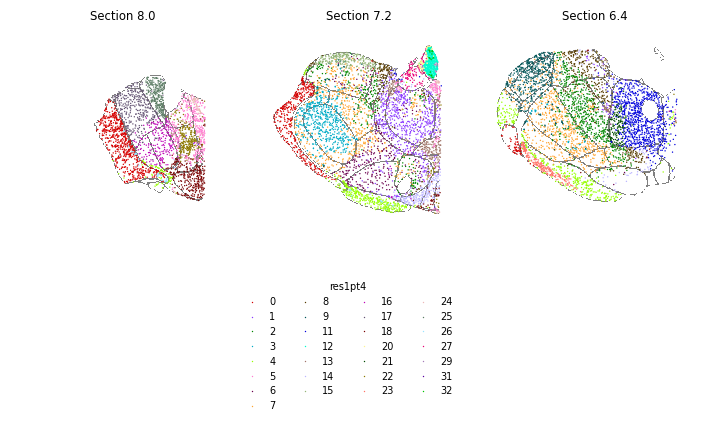

In [11]:
# plot CCF overlaid on the SpaGCN domains
fig_spagcn_overlay = cplots.plot_ccf_overlay(
    obs_spagcn_erode,
    ccf_images_left_hemi,
    point_hue=predicted_col,
    point_palette=color_palette,
    min_group_count=0,
    sections=cplots.TH_EXAMPLE_Z_SECTIONS,
    separate_figs=False,
    figsize=(9,3),
    legend="cells",
    bg_cells=None,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    point_size=1,
    # edge_color="black",
    boundary_img=ccf_boundaries_left_hemi,
    custom_xy_lims=[2.5, 6, 7, 4],
)
fig_spagcn_overlay[0].savefig(f'../../results/fig4A_spaGCN_domains_ccf_overlay_3sections_res{res_str}.pdf', 
            transparent=True, bbox_inches='tight')

### Fig. 5B | Highlights of interesting SpaGCN domains

#### AD, AV, AM : Domain 25, 17, 16

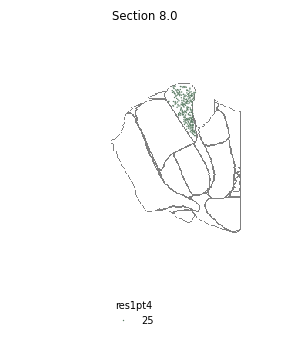

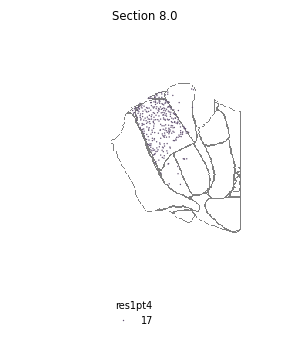

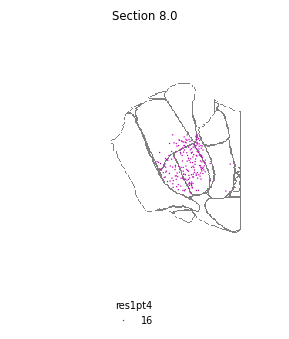

In [12]:
# plot ATN domain examples
structures = ['AD', 'AM', 'AV']
domain_ids = [25, 17, 16]
section = [cplots.TH_EXAMPLE_Z_SECTIONS[0]]

for i, domain in enumerate(domain_ids):
    obs_spagcn_erode_temp = obs_spagcn_erode[obs_spagcn_erode[predicted_col] == domain]
    structure = structures[i]

    fig_spagcn_overlay = cplots.plot_ccf_overlay(
        obs_spagcn_erode_temp,
        ccf_images_left_hemi,
        point_hue=predicted_col,
        point_palette=color_palette,
        min_group_count=0,
        sections=section,
        separate_figs=False,
        figsize=(9,3),
        legend="cells",
        bg_cells=None,
        section_col=section_col,
        x_col=x_col,
        y_col=y_col,
        point_size=1,
        # edge_color="black",
        boundary_img=ccf_boundaries_left_hemi,
        custom_xy_lims=[2.5, 6, 7, 4],
    )
    fig_spagcn_overlay[0].savefig(f'../../results/fig4B_spaGCN_examples_{structure}_domain{domain}.pdf', 
                transparent=True, bbox_inches='tight')

#### PF : Domain 21 & 11

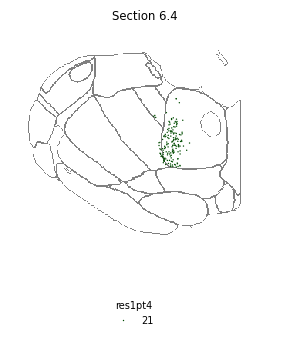

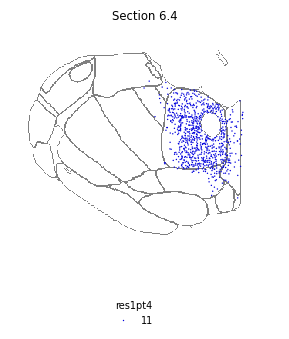

In [13]:
# plot PF domain examples
structure = 'PF'
domain_ids = [21, 11]
section = [cplots.TH_EXAMPLE_Z_SECTIONS[2]]

for domain in domain_ids:
    obs_spagcn_erode_temp = obs_spagcn_erode[obs_spagcn_erode[predicted_col] == domain]

    fig_spagcn_overlay = cplots.plot_ccf_overlay(
        obs_spagcn_erode_temp,
        ccf_images_left_hemi,
        point_hue=predicted_col,
        point_palette=color_palette,
        min_group_count=0,
        sections=section,
        separate_figs=False,
        figsize=(9,3),
        legend="cells",
        bg_cells=None,
        section_col=section_col,
        x_col=x_col,
        y_col=y_col,
        point_size=1,
        # edge_color="black",
        boundary_img=ccf_boundaries_left_hemi,
        custom_xy_lims=[2.5, 6, 7, 4],
    )
    fig_spagcn_overlay[0].savefig(f'../../results/fig4B_spaGCN_examples_{structure}_domain{domain}.pdf', 
                transparent=True, bbox_inches='tight')

#### RT : Domain 0

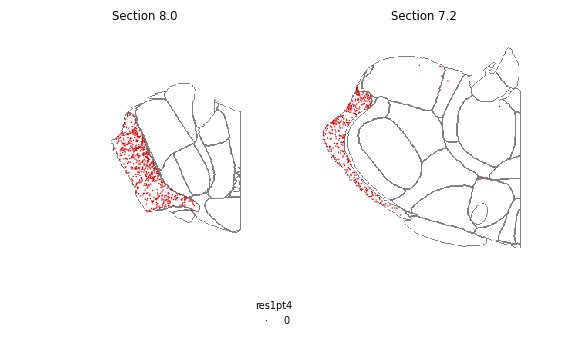

In [14]:
# plot RT domain examples
structure = 'RT'
domain_ids = [0]
section = cplots.TH_EXAMPLE_Z_SECTIONS[0:2]

for domain in domain_ids:
    obs_spagcn_erode_temp = obs_spagcn_erode[obs_spagcn_erode[predicted_col] == domain]

    fig_spagcn_overlay = cplots.plot_ccf_overlay(
        obs_spagcn_erode_temp,
        ccf_images_left_hemi,
        point_hue=predicted_col,
        point_palette=color_palette,
        min_group_count=0,
        sections=section,
        separate_figs=False,
        figsize=(9,3),
        legend="cells",
        bg_cells=None,
        section_col=section_col,
        x_col=x_col,
        y_col=y_col,
        point_size=1,
        # edge_color="black",
        boundary_img=ccf_boundaries_left_hemi,
        custom_xy_lims=[2.5, 6, 7, 4],
    )
    fig_spagcn_overlay[0].savefig(f'../../results/fig4B_spaGCN_examples_{structure}_domain{domain}.pdf', 
                transparent=True, bbox_inches='tight')

#### PVT : Domains 24 & 5

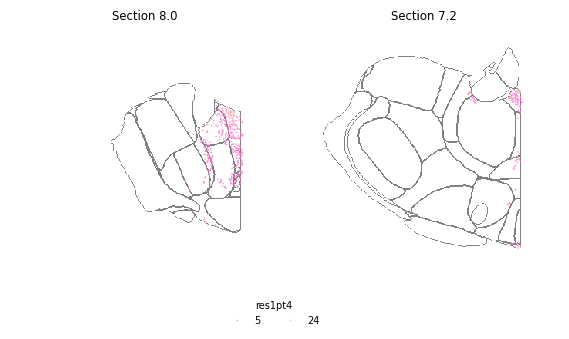

In [15]:
# plot PVT domain examples
structure = 'PVT'
domain_ids = [24,5]
section = cplots.TH_EXAMPLE_Z_SECTIONS[0:2]

obs_spagcn_erode_temp = obs_spagcn_erode[obs_spagcn_erode[predicted_col].isin(domain_ids)]

fig_spagcn_overlay = cplots.plot_ccf_overlay(
    obs_spagcn_erode_temp,
    ccf_images_left_hemi,
    point_hue=predicted_col,
    point_palette=color_palette,
    min_group_count=0,
    sections=section,
    separate_figs=False,
    figsize=(9,3),
    legend="cells",
    bg_cells=None,
    section_col=section_col,
    x_col=x_col,
    y_col=y_col,
    point_size=1,
    # edge_color="black",
    boundary_img=ccf_boundaries_left_hemi,
    custom_xy_lims=[2.5, 6, 7, 4],
)
fig_spagcn_overlay[0].savefig(f'../../results/fig4B_spaGCN_examples_{structure}_domain{domain}.pdf', 
            transparent=True, bbox_inches='tight')

#### MDm,l : Domain 1

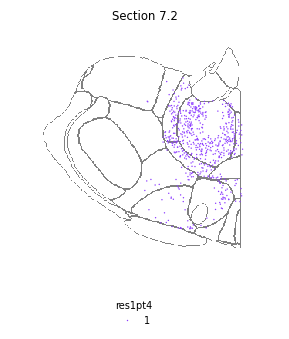

In [16]:
# plot RT domain examples
structure = 'MD'
domain_ids = [1]
section = [cplots.TH_EXAMPLE_Z_SECTIONS[1]]

for domain in domain_ids:
    obs_spagcn_erode_temp = obs_spagcn_erode[obs_spagcn_erode[predicted_col] == domain]

    fig_spagcn_overlay = cplots.plot_ccf_overlay(
        obs_spagcn_erode_temp,
        ccf_images_left_hemi,
        point_hue=predicted_col,
        point_palette=color_palette,
        min_group_count=0,
        sections=section,
        separate_figs=False,
        figsize=(9,3),
        legend="cells",
        bg_cells=None,
        section_col=section_col,
        x_col=x_col,
        y_col=y_col,
        point_size=1,
        # edge_color="black",
        boundary_img=ccf_boundaries_left_hemi,
        custom_xy_lims=[2.5, 6, 7, 4],
    )
    fig_spagcn_overlay[0].savefig(f'../../results/fig4B_spaGCN_examples_{structure}_domain{domain}.pdf', 
                transparent=True, bbox_inches='tight')

### Fig. 5C | Similarity heatmap of SpaGCN domains vs CCFv3 structures

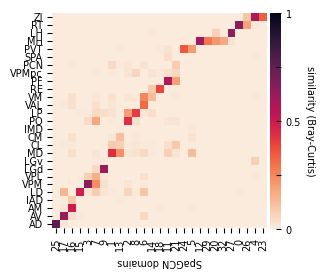

In [17]:
# ccf region order here is fairly arbitrary 
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_spagcn_erode, 
                            y_col=ccf_label, 
                            x_col=predicted_col, 
                            y_names=regions_nsf_spagcn, 
                            x_names=sorted(obs_spagcn[predicted_col].unique()),
                            metric='braycurtis')

y_order, x_order = dm.order_distances_x_to_y(dist, 
                                             reorder_y=False,
                                             min_similarity_x=0.1)

fig_spagcn = dm.plot_ordered_similarity_heatmap(dist, 
                                         y_order=y_order, 
                                         x_order=x_order, 
                                         y_names=y_names, 
                                         x_names=x_names)

fig_spagcn.set_size_inches(3.3,2.8)
fig_spagcn.gca().invert_yaxis()
plt.xlabel("SpaGCN domains", rotation=180)

fig_spagcn.savefig(f'../../results/fig4C_spagcn_ccf_similarity_heatmap_fixed_order.pdf', 
                    transparent=True, bbox_inches='tight')

## Fig. 5D-F | NSF, non-negative spatial factors/patterns

In [18]:
# Load NSF anndata object
adata = ad.read_zarr("/root/capsule/data/nsf_2000_adata/nsf_2000_adata.zarr")
adata.X = adata.X.toarray()
adata.X = np.log2(1 + adata.X*1e6/np.sum(adata.X, axis=1, keepdims=True))

# filter by thalamus coords to tighten up the image
adata = abc.filter_by_thalamus_coords(adata)

In [19]:
# NSF patterns are stored in the obs
obs_nsf = adata.obs

# erode the CCF structures
obs_nsf_erode, ccf_label = cerd.label_cells_by_eroded_ccf(obs_nsf.copy(), ccf_images_left_hemi, ccf_level=ccf_level)

In [20]:
nsf_cols = [f"nsf{i}" for i in range(30)]
nsf_labels = range(30)

### Fig5C - NSF patterns in 3 example sections

In [21]:
# top patterns by # of cells
# across all 3 example sections
top_patterns_sections3 = obs_nsf.loc[obs_nsf[section_col].isin(cplots.TH_EXAMPLE_Z_SECTIONS), nsf_cols].max(axis=0).loc[lambda x: x>0.25].sort_values(ascending=False)

# per section (informational only; not used for plotting)
top_patterns_sec64 = obs_nsf.loc[obs_nsf[section_col]==cplots.TH_EXAMPLE_Z_SECTIONS[0], nsf_cols].max(axis=0).loc[lambda x: x>0.25].sort_values(ascending=False)
top_patterns_sec72 = obs_nsf.loc[obs_nsf[section_col]==cplots.TH_EXAMPLE_Z_SECTIONS[1], nsf_cols].max(axis=0).loc[lambda x: x>0.25].sort_values(ascending=False)
top_patterns_sec80 = obs_nsf.loc[obs_nsf[section_col]==cplots.TH_EXAMPLE_Z_SECTIONS[2], nsf_cols].max(axis=0).loc[lambda x: x>0.25].sort_values(ascending=False)

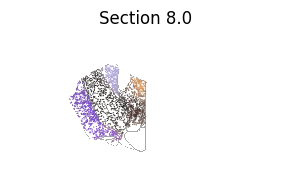

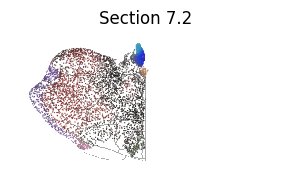

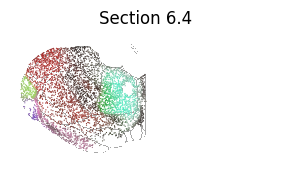

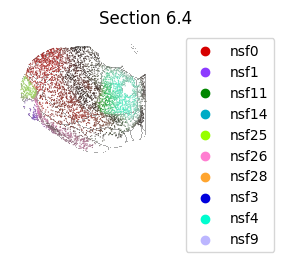

In [22]:
# reset to only plot thalamus structures
cplots.CCF_REGIONS_DEFAULT = abc.get_thalamus_names()

# patterns to plot
fig4_nsf_patterns = top_patterns_sections3.index[:10].sort_values()

# manually selecting bright/light colors, as overlapping patterns will generate
# greyish/brownish colors
color_list = glasbey[:6]+glasbey[7:8]+glasbey[10:12]+glasbey[13:14]

kwargs = dict(
            ccf_images=ccf_images_left_hemi,
            boundary_img=ccf_boundaries_left_hemi,
            section_col=section_col,
            x_col=x_col,   
            y_col=y_col,
            normalize_by=None,
            dark_background=False,
)

# save as pngs to save space
for sec in cplots.TH_EXAMPLE_Z_SECTIONS:
    fig = cplots.plot_multichannel_overlay(
                    obs_nsf,
                    fig4_nsf_patterns,
                    sec,
                    colors=color_list,
                    point_size=3,
                    legend=False,
                    figsize=(3.5,3),
                    **kwargs,
                    )
    fig.savefig(f"/results/fig4D_nsf_top10_patterns_overlay_sec{int(sec*10)}.png", 
                transparent=True, bbox_inches='tight', dpi=1200)
    
# make one pdf figure to have a vector graphic of the legend
fig = cplots.plot_multichannel_overlay(
                    obs_nsf,
                    fig4_nsf_patterns,
                    sec,
                    colors=color_list,
                    point_size=3,
                    legend=True,
                    figsize=(3.5,3),
                    **kwargs,
                    )
fig.savefig(f"/results/fig4D_nsf_top10_patterns_overlay_sec{int(sec*10)}_legend.pdf", 
                    transparent=True, bbox_inches='tight')

### Fig5E | Highlights of interesting NSF patterns

In [23]:
# set formatting parameters for plots
kwargs_fig4E = dict(
    categorical=False,
    point_palette='Greens', 
    legend=None,
    separate_figs=False,
    figsize=(0.85, 0.85),
    point_size=0.5,
    section_col=section_col,
    x_col = x_col,
    y_col = y_col,
    custom_xy_lims=cplots.XY_LIMS_TH_LEFT_HEMI,
    boundary_img=ccf_boundaries_left_hemi,
)

In [24]:
highlight_patterns = [0, 1, 9, 11, 14, 16, 17, 23, 27, 28]
highlight_patterns_str = [f'nsf{x}' for x in highlight_patterns]

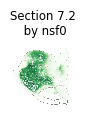

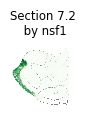

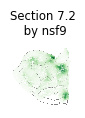

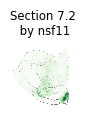

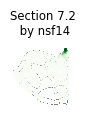

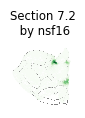

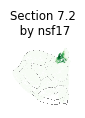

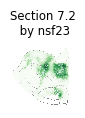

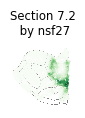

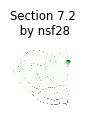

In [25]:
for pattern in highlight_patterns_str:
    section = [cplots.TH_EXAMPLE_Z_SECTIONS[1]]
    
    fig_nsf = cplots.plot_ccf_overlay(
        obs_nsf, 
        ccf_images_left_hemi, 
        point_hue=pattern, 
        sections=section,
        **kwargs_fig4E
        )
    fig_nsf[0].savefig(f'/results/fig4E_nsf_ccf_overlay_sec{int(section[0]*10)}_{pattern}.pdf',
                        transparent=True, bbox_inches='tight', dpi=1200)

### Fig. 5F | Similarity heatmap of NSF patterns vs CCFv3 structures

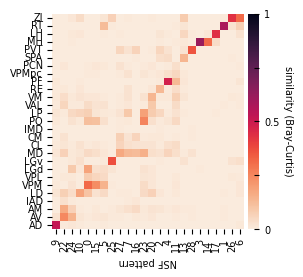

In [26]:
# order here is following thalamoseq fig 1
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_nsf_erode, 
                            y_col=ccf_label, 
                            x_col=nsf_cols, 
                            y_names=regions_nsf_spagcn, 
                            x_names=nsf_labels,
                            metric='braycurtis'
                            )

y_order, x_order = dm.order_distances_x_to_y(dist, 
                                          reorder_y=False, 
                                          min_similarity_x=0.1)

# plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 7})
fig_nsf_sim = dm.plot_ordered_similarity_heatmap(
    dist, 
    label="similarity (Bray-Curtis)",
    y_order=y_order, 
    x_order=x_order, 
    y_names=y_names, 
    x_names=x_names,
)
fig_nsf_sim.set_size_inches(3.0,2.8)
fig_nsf_sim.gca().invert_yaxis()
plt.xlabel("NSF pattern", rotation=180)
plt.savefig("/results/nsf_ccf_similarity_heatmap_ccf_order.pdf", transparent=True)